In [1]:
from datetime import datetime

import math
import os
import random

import nilearn as nil
from nilearn import image as nil_image
import numpy as np

from scipy import ndimage
from sklearn.metrics import confusion_matrix
from PIL import Image

import torch
import torch.autograd as dif
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel

from torch import optim
from torch.nn.modules.utils import _triple
from torch.utils.data import Dataset, DataLoader, random_split
# This is imported to fix any data error in a batch
from torch.utils.data.dataloader import default_collate
from torchvision import transforms, utils

from tqdm import tqdm


# Custom import
from train_test_set import train_test_subs, params

In [2]:
class FmriDataset(Dataset):

    def __init__(self, params, data_dir='/data/fmri/data', mask_path='/data/fmri/mask/caudate._mask.nii',
                 img_shape=(57, 68, 49, 135)):
        self.data_dir, self.params = data_dir, params
        self.img_timesteps = params.img_timesteps
        self.num_classes = params.nClass
        self.device = torch.device(
            "cuda:0" if torch.cuda.is_available() else "cpu")
        self.mask_path, self.img_shape = mask_path, img_shape
        self.samples = []
        # Initialize the image indexes with their scores
        self.index_data()
        # self.mask = self.read_mask()
        self.class_weights = self.find_weights()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        try:
            img_path, score = self.samples[idx]
            score = self.get_class(score)
            img = self.read_image(img_path)
            # img = self.apply_mask(img)
            img = self.apply_temporal_aug(img)
            return img, score
        except Exception:
            return None

    def index_data(self):
        """
        Stores all the image_paths with their respective scores/classes in the 
        """
        self.weights = {i: 0 for i in range(self.num_classes)}
        for sub in os.listdir(self.data_dir):
            if sub not in self.params.subs:
                # Don't consider subjects that are not in the subs set
                continue
            sub_dir = os.path.join(self.data_dir, sub)
            preproc_dir = os.path.join(sub_dir, f'{sub}.preproc')
            for img_name in os.listdir(preproc_dir):
                img_path = os.path.join(preproc_dir, img_name)
                score = self.get_score(sub_dir, img_name)
                score_class = self.get_class(score)
                # Since we are randomly sampling 30 timesteps from each scan of 135 timesteps,
                # I am considering the same image for "n" times so that we have more data to train
                n = 5
                for k in range(n):
                    self.weights[score_class] += 1
                    self.samples.append((img_path, score))

    def get_class(self, score):
        """
        Categorize each score into one of the five classes (bins)
        Returns values from 0-5 (6 classes)
        Classes: (0, 10), (10, 20), (20, 40), (40, 60), (60, 80), (80, 100)
        """
        if score < 10:
            return 0
        elif score >= 10 and score < 20:
            return 1
        elif score >= 20 and score < 40:
            return 2
        elif score >= 40 and score < 60:
            return 3
        elif score >= 60 and score < 80:
            return 4
        else:
            return 5

    def get_score(self, sub_dir, img_name):
        score_file = '0back_VAS-f.1D' if '0back' in img_name else '2back_VAS-f.1D'
        score_path = os.path.join(sub_dir, score_file)
        with open(score_path, 'r') as s_f:
            scores = [int(str(score.replace('\n', ''))) for score in s_f]

        task_num = img_name.split('.')[1]
        score_num = int(task_num[-1:])
        return scores[score_num]

    def read_image(self, img_path):
        nX, nY, nZ, nT = self.img_shape
        img = nil_image.load_img(img_path)
        img = img.get_fdata()[:nX, :nY, :nZ, :nT]
        img = torch.tensor(img, dtype=torch.float, device=self.device)
        img = (img - img.mean()) / img.std()
        return img

    def read_mask(self):
        nX, nY, nZ, _ = self.img_shape
        mask_img = nil.image.load_img(self.mask_path)
        mask_img = mask_img.get_fdata()[:]
        mask_img = np.asarray(mask_img)
        dilated_mask = np.zeros((nX, nY, nZ))
        ratio = round(mask_img.shape[2]/nZ)
        for k in range(nZ):
            temp = ndimage.morphology.binary_dilation(
                mask_img[:, :, k*ratio], iterations=1) * 1
            temp_img = Image.fromarray(np.uint8(temp*255))
            dilated_mask[:, :, k] = np.array(temp_img.resize((nY, nX)))

        dilated_mask = (dilated_mask > 64).astype(int)
        dilated_mask = torch.tensor(
            dilated_mask, dtype=torch.float, device=self.device)
        return dilated_mask

    def apply_mask(self, img):
        nT = img.shape[-1]
        for i in range(nT):
            img[:, :, :, i] = torch.mul(img[:, :, :, i], self.mask)
        return img

    def apply_temporal_aug(self, img):
        """
        Image shape: X, Y, Z, t=135
        So, e.g: take any 30 random timesteps from the 135 available in ascending order 
        """
        total_timesteps = img.shape[3]
        rand_timesteps = sorted(random.sample(
            range(0, total_timesteps), self.img_timesteps))
        # Move time axes to the first place followed by X, Y, Z
        img = img.permute(3, 0, 1, 2)
        img = torch.tensor(np.take(img.cpu().numpy(), rand_timesteps, axis=0))
        return img

    def find_weights(self):
        weights = dict(self.weights)
        key_max = max(weights.keys(), key=(lambda k: weights[k]))
        max_value = weights[key_max]
        for key in weights.keys():
            # Add 1 to the denominator to avoid divide by zero error (in some cases)
            weights[key] = max_value / (weights[key]+1)

        return weights

In [3]:
class FmriModel(nn.Module):

    def __init__(self, params):
        super(FmriModel, self).__init__()

        self.ndf = params.ndf
        # "nc" is the number of timesteps in the input scan (t=nc in this case)
        self.nc = params.img_timesteps
        self.nClass = params.nClass

        # Input to the model is (t, 57, 68, 49) <== (t, x, y, z)
        # 't' can change based on the "img_timesteps" value (number of timesteps to be sampled from one scan)

        self.conv1 = nn.Sequential(
            nn.Conv2d(params.nX, self.ndf, 5, 2, bias=False),
            nn.ReLU(True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(self.ndf*1, self.ndf*2, 5, 2, bias=False),
            nn.BatchNorm2d(self.ndf*2),
            nn.ReLU(True),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(self.ndf*2, self.ndf*4, 5, 2, bias=False),
            nn.BatchNorm2d(self.ndf*4),
            nn.ReLU(True),
        )

        self._to_linear, self._to_lstm = None, None
        x = torch.randn(params.batchSize*self.nc,
                        params.nX, params.nY, params.nZ)
        self.convs(x)

        self.lstm = nn.LSTM(input_size=3840, hidden_size=256,
                            num_layers=1, batch_first=True)

        self.fc1 = nn.Linear(256, self.ndf * 1)

        self.fc2 = nn.Sequential(
            nn.Linear(self.ndf * 1, self.nClass),
        )

    def convs(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        if self._to_linear is None:
            # First pass: done to know what the output of the convnet is
            self._to_linear = int(x[0].shape[0]*x[0].shape[1]*x[0].shape[2])
            # For LSTM input, divide by batch_size and time_steps (i.e. / by self.nc and 1)
            self._to_lstm = int(self._to_linear/self.nc)

        return x

    def forward(self, x):
        batch_size, timesteps, c, h, w = x.size()
        # Merge batch_size and timesteps into one dimension
        x = x.view(batch_size*timesteps, c, h, w)
        cnn_out = self.convs(x)

        # Prepare the output from CNN to pass through the LSTM layer
        r_in = cnn_out.view(batch_size, timesteps, -1)

        # Flattening is required when we use DataParallel
        self.lstm.flatten_parameters()

        # Get output from the LSTM
        r_out, (h_n, h_c) = self.lstm(r_in)

        # Pass the output of the LSTM to FC layers
        r_out = self.fc1(r_out[:, -1, :])
        r_out = self.fc2(r_out)

        # Apply softmax to the output and return it
        return F.log_softmax(r_out, dim=1)

In [4]:
def my_collate(batch):
    # Function to catch errors while reading a batch of fMRI scans
    # Removes any NoneType values from the batch to prevent errors while training
    batch = list(filter(lambda x: x is not None, batch))
    return default_collate(batch)
    

def train_test_length(total, test_pct=0.2):
    train_count = int((1-test_pct)*total)
    test_count = total - train_count
    return train_count, test_count


def train(net, train_loader, loss_function, optimizer, test_loader):
    print('Training...')
    for epoch in range(params.nEpochs):
        for batch in tqdm(train_loader):
            inputs, labels = batch[0].to(device), batch[1].to(device)
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
        
        _, _, train_acc = test(net, train_loader)
        _, _, test_acc = test(net, test_loader)

        print(f'Epoch: {epoch} | Loss: {loss} | Train Acc: {train_acc} | Test Acc: {test_acc}')

    return net


def test(net, test_loader):
    # print('Testing...')
    correct = 0
    total = 0

    preds = []
    actual = []

    with torch.no_grad():
        for data in tqdm(test_loader):
            if not data:
                continue
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            class_outputs = net(inputs)
            _, class_prediction = torch.max(class_outputs.data, 1)
            total += labels.size(0)
            correct += (class_prediction == labels).sum().item()
            preds.extend(list(class_prediction.to(dtype=torch.int64)))
            actual.extend(list(labels.to(dtype=torch.int64)))

    acc = 100*correct/total
    # print(f'Accuracy: {acc}')
    return preds, actual, acc


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
k_fold = 1
params.nEpochs = 10
params.batchSize = 8
accs = []
cf_matrix = []
learning_rate = 0.0001
sample_timesteps = 100
params.update({'img_timesteps': sample_timesteps})

print(f'Parameters: LR: {learning_rate} | Epochs: {params.nEpochs} | K-folds: {k_fold} | BatchSize: {params.batchSize} | Sample timesteps: {sample_timesteps}')


Parameters: LR: 0.0001 | Epochs: 10 | K-folds: 1 | BatchSize: 8 | Sample timesteps: 100


# Experiment code

In [6]:
class FmriGradModel(nn.Module):
    
    def __init__(self, params):
        super(FmriGradModel, self).__init__()
        
        # Get pretrained Fmri model
        self.fmri_model = FmriModel(params=params)
        n_gpus = torch.cuda.device_count()
        if (device.type == 'cuda') and (n_gpus > 1):
            self.fmri_model = nn.DataParallel(self.fmri_model, list(range(n_gpus)))
            
        self.fmri_model.load_state_dict(torch.load('/home/ashish/Documents/github/fmri-TBI/code/01_03_2021_10_23-fold-0-lr-0.0001.pth'))
        
        
        # Placeholder for the gradients
        self.gradients = None
        
    def activations_hook(self, grad):
        self.gradients = grad
        
    def features_conv(self, x):
        batch_size, timesteps, c, h, w = x.size()
        # Merge batch_size and timesteps into one dimension
        x = x.view(batch_size*timesteps, c, h, w)
        
        x = self.fmri_model.module.conv1(x)
        x = self.fmri_model.module.conv2(x)
        return self.fmri_model.module.conv3(x)
    
    def features_others(self, x):        
        self.fmri_model.module.lstm.flatten_parameters()

        # Get output from the LSTM
        r_out, (h_n, h_c) = self.fmri_model.module.lstm(x)

        # Pass the output of the LSTM to FC layers
        r_out = self.fmri_model.module.fc1(r_out[:, -1, :])
        r_out = self.fmri_model.module.fc2(r_out)

        # Apply softmax to the output and return it
        return F.log_softmax(r_out, dim=1)
        
    def forward(self, x):
        batch_size, timesteps, c, h, w = x.size()
        
        x = self.features_conv(x)
        
        # Register the hook
        h = x.register_hook(self.activations_hook)
        
        # Apply the remaining layers
        x = x.view(batch_size, timesteps, -1)
        return self.features_others(x)
    
    def get_activations_gradient(self):
        # Method for gradient extraction
        return self.gradients
    
    def get_activations(self, x):
        return self.features_conv(x)

In [7]:
fmri = FmriGradModel(params)

In [8]:
# Set to evaluation mode
fmri.eval()

FmriGradModel(
  (fmri_model): DataParallel(
    (module): FmriModel(
      (conv1): Sequential(
        (0): Conv2d(57, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (1): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv3): Sequential(
        (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (lstm): LSTM(3840, 256, batch_first=True)
      (fc1): Linear(in_features=256, out_features=64, bias=True)
      (fc2): Sequential(
        (0): Linear(in_features=64, out_features=6, bias=True)
      )
    )
  )
)

In [9]:
# Load images to test for forward passes
train_subs, test_subs = train_test_subs(test_pct=0.2)
print(f'Train subs: {train_subs} || Test subs: {test_subs}')

params.update({'subs': train_subs})
trainset = FmriDataset(params=params)
params.update({'subs': test_subs})
testset = FmriDataset(params=params)

class_weights = torch.FloatTensor(
    [trainset.class_weights[i] for i in range(params.nClass)]).to(device)

train_loader = DataLoader(
        trainset, batch_size=params.batchSize, shuffle=True, collate_fn=my_collate)
test_loader = DataLoader(
    testset, batch_size=params.batchSize, shuffle=True, collate_fn=my_collate)

Train subs: ['sub-hc030', 'sub-hc034', 'sub-hc004', 'sub-hc001', 'sub-hc011', 'sub-hc021', 'sub-hc003', 'sub-hc009', 'sub-hc029', 'sub-hc007', 'sub-hc012', 'sub-hc019', 'sub-hc005', 'sub-hc028', 'sub-hc024', 'sub-hc031', 'sub-hc025', 'sub-hc010', 'sub-hc002', 'sub-hc022', 'sub-hc016', 'sub-tbi013', 'sub-tbi036', 'sub-tbi001', 'sub-tbi025', 'sub-tbi004', 'sub-tbi017', 'sub-tbi035', 'sub-tbi016', 'sub-tbi023', 'sub-tbi005', 'sub-tbi008', 'sub-tbi010', 'sub-tbi027', 'sub-tbi018', 'sub-tbi006', 'sub-tbi012', 'sub-tbi034', 'sub-tbi015', 'sub-tbi009', 'sub-tbi019', 'sub-tbi022', 'sub-tbi024'] || Test subs: ['sub-hc033', 'sub-hc020', 'sub-hc023', 'sub-tbi002', 'sub-tbi003', 'sub-tbi011', 'sub-tbi014', 'sub-tbi020', 'sub-tbi029', 'sub-tbi030']


In [10]:
imgs, scores = next(iter(train_loader))

In [11]:
scores

tensor([0, 5, 2, 2, 5, 0, 5, 4])

In [12]:
preds = fmri(imgs)

In [13]:
_, class_prediction = torch.max(preds.data, 1)

In [14]:
class_prediction

tensor([0, 5, 5, 2, 5, 0, 5, 4])

In [15]:
preds

tensor([[-2.6131e-03, -7.5353e+00, -6.6624e+00, -9.9262e+00, -7.3848e+00,
         -8.9623e+00],
        [-9.5114e+00, -7.8405e+00, -8.5160e+00, -6.0449e+00, -7.2433e+00,
         -3.7597e-03],
        [-3.3204e+00, -5.8140e+00, -7.7978e+00, -3.1478e+00, -2.9630e+00,
         -1.4404e-01],
        [-5.3396e+00, -4.6615e+00, -1.5729e-02, -8.8961e+00, -6.8593e+00,
         -8.6857e+00],
        [-6.2822e+00, -7.4924e+00, -4.2323e+00, -6.0478e+00, -6.1292e+00,
         -2.1722e-02],
        [-9.1174e-03, -5.7846e+00, -6.4308e+00, -5.5346e+00, -8.0160e+00,
         -9.0929e+00],
        [-8.2400e+00, -9.5053e+00, -1.0360e+01, -6.7412e+00, -6.4233e+00,
         -3.1795e-03],
        [-8.2506e+00, -7.0856e+00, -7.9803e+00, -9.3564e+00, -1.8089e-03,
         -8.1787e+00]], grad_fn=<LogSoftmaxBackward>)

In [16]:
preds[0][0].backward()

In [17]:
gradients = fmri.get_activations_gradient()
gradients.shape

torch.Size([800, 256, 5, 3])

In [18]:
# Pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
pooled_gradients.shape

torch.Size([256])

In [19]:
# Get the activations of the last convolutional layer
activations = fmri.get_activations(imgs).detach()

In [20]:
activations.shape

torch.Size([800, 256, 5, 3])

In [22]:
# Weight the channels by corresponding gradients
for i in range(256):
    activations[:, i, :, :] *= pooled_gradients[i]

In [26]:
# Average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
heatmap.shape

torch.Size([800, 5, 3])

In [27]:
# Relu on top of the heatmap
heatmap = np.maximum(heatmap, 0)

In [29]:
# Normalize the heatmap
heatmap /= torch.max(heatmap)

In [34]:
heatmap.squeeze().shape

torch.Size([800, 5, 3])

#### The following plot is a single channel of size 5x3
- Need to interpolate it to the original size of the input 67x49

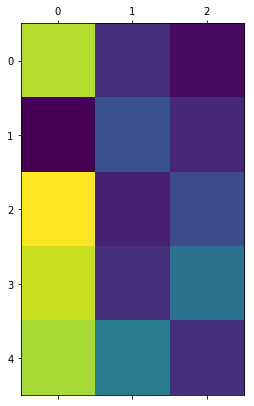

In [39]:
import matplotlib.pyplot as plt
plt.matshow(heatmap.squeeze()[0])

In [46]:
# Read the corresponding image
scan = nil_image.load_img('/data/fmri/data/sub-hc030/sub-hc030.preproc/0back.r01.scale.nii.gz')
scan = scan.get_fdata()
scan.shape

(57, 68, 49, 135)

In [47]:
img = scan[:, :, :, 0]
img.shape

(57, 68, 49)

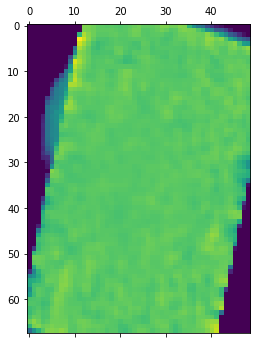

In [51]:
plt.matshow(np.mean(img, axis=0))

In [52]:
import cv2

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[2]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + np.mean(img, axis=0)
plt.matshow(superimposed_img)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

# Training Code below

In [ ]:

for k in range(k_fold):
    train_subs, test_subs = train_test_subs(test_pct=0.2)
    print(f'Train subs: {train_subs} || Test subs: {test_subs}')
    # print(f'Train-subs: {len(train_subs)}')
    # print(f'Test-subs: {len(test_subs)}')
    params.update({'subs': train_subs})
    trainset = FmriDataset(params=params)
    params.update({'subs': test_subs})
    testset = FmriDataset(params=params)

    class_weights = torch.FloatTensor(
        [trainset.class_weights[i] for i in range(params.nClass)]).to(device)
    # Initialize the model
    net = FmriModel(params=params).to(device)
    # Distributed training on multiple GPUs if available
    n_gpus = torch.cuda.device_count()
    print(f'Number of GPUs available: {n_gpus}')
    if (device.type == 'cuda') and (n_gpus > 1):
        net = nn.DataParallel(net, list(range(n_gpus)))

    loss_function = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    train_loader = DataLoader(
        trainset, batch_size=params.batchSize, shuffle=True, collate_fn=my_collate)
    test_loader = DataLoader(
        testset, batch_size=params.batchSize, shuffle=True, collate_fn=my_collate)
    
    # You can use my_collate() function inside the dataloader to check for errors while reading corrupted scans

    net = train(net, train_loader, loss_function, optimizer, test_loader)
    # Save the model checkpoint
    current_time = datetime.now()
    current_time = current_time.strftime("%m_%d_%Y_%H_%M")
    torch.save(net.state_dict(), f'{current_time}-fold-{k}-lr-{learning_rate}.pth')
    preds, actual, acc = test(net, test_loader)
    accs.append(acc)

    # For confusion matrix
    preds = [int(k) for k in preds]
    actual = [int(k) for k in actual]

    cf = confusion_matrix(actual, preds, labels=list(range(params.nClass)))
    cf_matrix.append(cf)
    with open('cf_matrices.txt', 'a') as cf_file:
        cf_file.write(str(cf) + '\n')


print(cf_matrix)
print(accs)
print(f'Avg Accuracy: {sum(accs)/len(accs)}')
print(f'Parameters: LR: {learning_rate} | Epochs: {params.nEpochs} | K-folds: {k_fold} | BatchSize: {params.batchSize} | Sample timesteps: {sample_timesteps}')

print(f'Train subs: {train_subs} || Test subs: {test_subs}')

with open('abc.txt', 'w') as abc_file:
    for cf in cf_matrix:
        abc_file.write(f'{cf}\n')
    abc_file.write(f'{accs}')
